# Exploring the Results of the Crawler

In [7]:
import pandas as pd
import numpy as np
import os
import psycopg2
from urllib.parse import urlparse
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from src import util

conn = conn = psycopg2.connect(database="gdelt_social_video", user="postgres")
pd.set_option('display.max_colwidth', -1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/claasmeiners/.virtualenvs/thesis/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [9]:
query = """SELECT left(crawling_status, 14) AS status, count(left(crawling_status, 14)) AS status_count 
            FROM articles GROUP BY status ORDER BY status_count DESC"""
df = pd.read_sql_query(query, conn)
df.head()

,status,status_count
0,Success,2376712
1,404,274107
2,410,101641
3,403,20556
4,HTTPSConnectio,12406


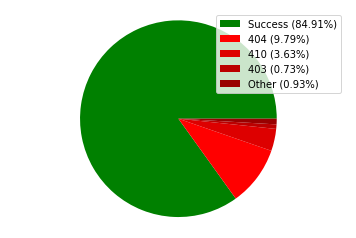

In [44]:
# We want the top 4 and all others summarized
values = list(df["status_count"][:4]) + [sum(df["status_count"][5:])]
statuses = list(df["status"][:4]) + ["Other"] 
labels = ["%s (%.2f%%)" % (status, value / sum(values) * 100) for value,status in zip(values,statuses)]
patches, texts = plt.pie(values, colors=['green', '#ff0000', '#dd0000', '#bb0000', '#990000'])
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.savefig(os.environ['FIGURES_PATH'] + "crawling_status.pdf", format="pdf")
plt.show()

## Number of pages with relevant videos by number of videos (from 3112)

In [5]:
df[df["video_count"] == 20].head(20)

,website_url,video_count
2496,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32844:panel-discussion-on-iran-irgc-and-sanctions&catid=9&Itemid=114,20
2497,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32844:panel-discussion-on-iran-irgc-and-sanctions&catid=9:terrorism&Itemid=114,20
2498,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32845:united-states-is-focused-on-iran-threat&catid=4&Itemid=109,20
2499,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32845:united-states-is-focused-on-iran-threat&catid=4:iran-general&Itemid=109,20
2500,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32846:iran-trying-to-subvert-us-sanctions&catid=8&Itemid=124,20
2501,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32846:iran-trying-to-subvert-us-sanctions&catid=8:nuclear&Itemid=124,20
2502,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32847:iran-opposition-s-position-grows-stronger-with-support-from-us-administration&catid=4&Itemid=109,20
2503,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32847:iran-opposition-s-position-grows-stronger-with-support-from-us-administration&catid=4:iran-general&Itemid=109,20
2504,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32849:iran-the-129-people-arrested-in-grand-bazaar-protests-will-not-be-released-soon&catid=5&Itemid=110,20
2505,https://www.iranfocus.com/en/index.php?option=com_content&view=article&id=32849:iran-the-129-people-arrested-in-grand-bazaar-protests-will-not-be-released-soon&catid=5:human-rights&Itemid=110,20


- 20: 0/11 (iranfocus.com)
- 18: 0/1 (drleonardcoldwell.com)
- 14: 3/3 (those are lists)
- 10: 5/5 (also lists)
- 9: 2/2 (also lists)
- 8: 2/14 (sunatimes.com , www.critiqueecho.com have related videos on the side)
- 7: 1.5/8 (www.evwind.es has related videos on the side)
- 6: 13/30 (www.acp.int, www.c-mw.net, www.gurtong.net, www.mymcmedia.org (2/3), hiphopnc.com, ipowerrichmond.com, theconservativetreehouse.com allows it in comments)
- 5: /22
- 2: (asiatoday.com/
- 1: (subset of 20) 13/20 (adelove.com, allafrica.com)

We have to more sophisticated analysis to figure out which videos are actually relevant to the article vs. which are in some sidebar etc.

###  Lets look at number of articles from that host, average number of videos as well as variance in number of videos.

In [6]:
df['hostname'] = [urlparse(url).hostname for url in df['website_url']]
analysis = df.groupby(['hostname']).agg(['count', 'sum', 'mean', 'std']).reset_index()
analysis.columns = ['hostname', 'count', 'sum', 'mean', 'std']
analysis[analysis['count'] < analysis['sum']].sort_values(['std'], ascending=True).head()

,hostname,count,sum,mean,std
538,www.cagesideseats.com,2,4,2.0,0.0
643,www.fbc.com.fj,16,32,2.0,0.0
269,northboundasia.com,2,4,2.0,0.0
611,www.eglobaltravelmedia.com.au,5,10,2.0,0.0
574,www.critiqueecho.com,3,24,8.0,0.0


**This can be used to train a classifier.**